In [11]:
# cargar un el arhivo CSV 
# uso la opcion para cargar el archivo desde mi pc al drive

from google.colab import files

uploaded=files.upload()

Saving hotel_bookings_preprocessed.csv to hotel_bookings_preprocessed (1).csv


In [0]:
import random

random.seed(1234)

In [13]:
# abrimos el archivo prepocesado que contiene solo los atributos que vamos a usar en el arbol
import io
import pandas as pd

df_booking = pd.read_csv('hotel_bookings_preprocessed.csv')

# eliminamos la columna de cancel_days_before_arrival, porque no la vamos a usar para la prediccion
df_booking = df_booking.drop(['cancel_days_before_arrival'], axis=1)

df_booking.head()

,Unnamed: 0,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_month_1,arrival_month_10,arrival_month_11,arrival_month_12,arrival_month_2,arrival_month_3,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,continent_Africa,continent_Antarctica,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,agent_b,company_b,meal_BB,meal_FB,meal_HB,meal_SC,market_seg_Aviation,market_seg_Complementary,market_seg_Corporate,market_seg_Direct,market_seg_Groups,market_seg_Offline TA/TO,market_seg_Online TA,dist_channel_Corporate,dist_channel_Direct,dist_channel_GDS,dist_channel_TA/TO,deposit_No Deposit,deposit_Non Refund,deposit_Refundable,cust_type_Contract,cust_type_Group,cust_type_Transient,cust_type_Transient-Party,adr_por_persona
0,0,0,342,0,0,2,0.0,0,0,0,0,3,0,107.675944,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.837972
1,1,0,737,0,0,2,0.0,0,0,0,0,4,0,107.675944,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.837972
2,2,0,7,0,1,1,0.0,0,0,0,0,0,0,75.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,75.000000
3,3,0,13,0,1,1,0.0,0,0,0,0,0,0,75.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,75.000000
4,4,0,0,0,2,2,0.0,0,0,0,0,0,0,107.000000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,53.500000


In [14]:
# analizamos el balanceo de la variable target
df_booking.is_canceled.value_counts(normalize=True)

0    0.737797
1    0.262203
Name: is_canceled, dtype: float64

In [15]:
# g)
# particiona el dataset manteniendo el balanceo
# 20% de los datos para usarlos como conjunto de evaluación (test set). 
# el resto para desarrollo

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

target='is_canceled'

mask = np.ones(df_booking.columns.shape, dtype=bool)
mask[0:2] = 0 #pongo false en las cols de target y indice
features=df_booking.columns[mask]

x_train, x_test, y_train, y_test = train_test_split(df_booking[features].values, df_booking[target].values,
                                                    test_size=0.2, random_state=42,stratify=df_booking[target].values)

print('Total: {}'.format(len(df_booking)))
print('Desarrollo 80 %: {}'.format(len(x_train)))
print('Test 20%: {}'.format(len(x_test)))


Total: 79225
Desarrollo 80 %: 63380
Test 20%: 15845


In [0]:
#g) 1.
#50 arboles con semillas random
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):

  # volvemos a dividir el dataset de desarrollo en entrenamiento 80% y validación 20%
  x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,
                                                      stratify=y_train)

  arbol_sklearn = DecisionTreeClassifier(criterion='gini',max_depth=7,min_samples_leaf=30, ccp_alpha=0,
                                         random_state=None)
  arbol_sklearn.fit(x_train_,y_train_)

  y_pred_val = arbol_sklearn.predict(x_val)

  if (len(recalls)>0):
    if (recalls[len(recalls)-1]<recall_score(y_val,y_pred_val) ):
        mejor_arbol_recall=arbol_sklearn
  else:
    mejor_arbol_recall=arbol_sklearn

  accs.append(accuracy_score(y_val,y_pred_val))
  precisions.append(precision_score(y_val,y_pred_val))
  recalls.append(recall_score(y_val,y_pred_val))
  f1s.append(f1_score(y_val,y_pred_val))



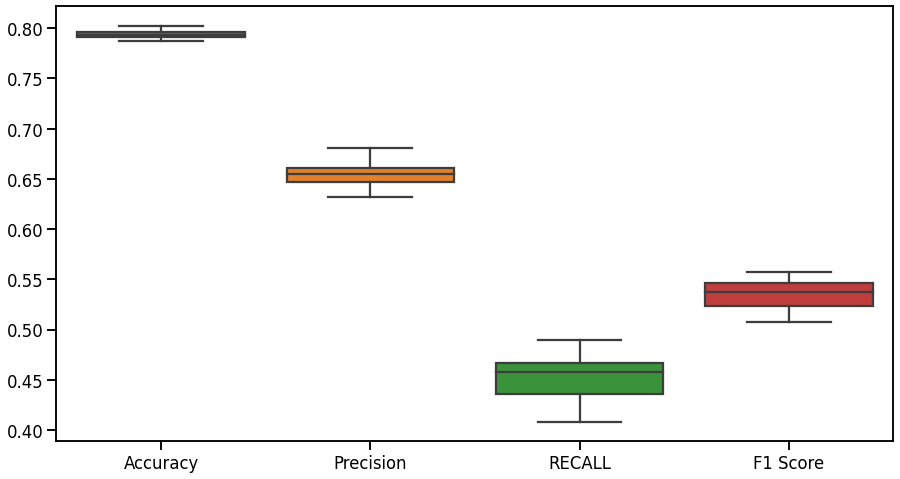

In [80]:
# graficamos las metricas de los 50 arboles
# piden graficar solo la que elegimos en el punto c) -> Recall; ver si sacamos las demas o destacamos RECALL
all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['RECALL']*len(recalls) + ['F1 Score']*len(f1s)

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [81]:
# vemos los atritbutos mas importantes ordenados por importancia
a = pd.DataFrame(arbol_sklearn.feature_importances_, df_booking[features].columns)
a.columns=["importancia"]

# solo muestro con valor mayor a cero
a[a.importancia>0].sort_values(by="importancia", ascending=False)


,importancia
lead_time,0.247387
market_seg_Online TA,0.222256
total_of_special_requests,0.213017
required_car_parking_spaces,0.122993
previous_cancellations,0.050123
cust_type_Transient,0.037088
deposit_Non Refund,0.033770
adr,0.029197
previous_bookings_not_canceled,0.020265
booking_changes,0.009355


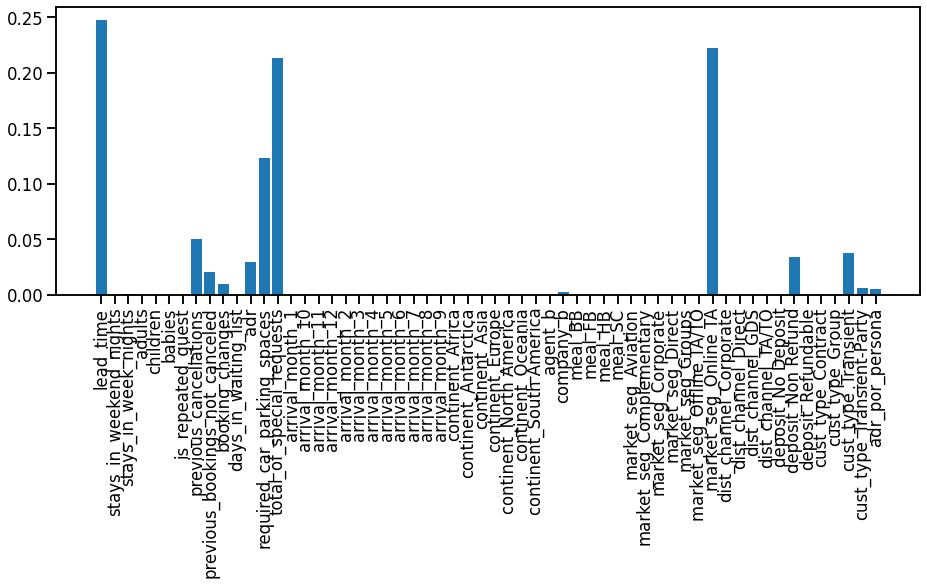

In [82]:
# grafico de importance featurs
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(features,arbol_sklearn.feature_importances_)
plt.xticks(features, rotation = 90)
plt.show()

In [83]:
# g) 2.
# armamos de nuevo el arbol con 50 folds de cross validation y variando con los hiperparametros
# sin poda
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,8)),
               'ccp_alpha':[0],
               'min_samples_leaf':list(range(1,21))}

kfoldcv = StratifiedKFold(n_splits=50)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(recall_score)
randomcv2 = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,
                               scoring=scorer_fn,cv=kfoldcv,n_iter=50,random_state=None)
randomcv2.fit(x_train_,y_train_)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=50, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
                                                    random_state=None,
   

In [84]:
# vemos los resultados del proceso
cv_results2 =pd.DataFrame(randomcv2.cv_results_)
cv_results2.sort_values(by=['mean_test_score'], ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,split20_test_score,split21_test_score,split22_test_score,split23_test_score,split24_test_score,split25_test_score,split26_test_score,split27_test_score,split28_test_score,split29_test_score,split30_test_score,split31_test_score,split32_test_score,split33_test_score,split34_test_score,split35_test_score,split36_test_score,split37_test_score,split38_test_score,split39_test_score,split40_test_score,split41_test_score,split42_test_score,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
17,0.236617,0.007727,0.001644,0.000064,11,7,gini,0,"{'min_samples_leaf': 11, 'max_depth': 7, 'crit...",0.454887,0.466165,0.417293,0.398496,0.437736,0.415094,0.460377,0.445283,0.486792,0.520755,0.458647,0.522556,0.458647,0.484962,0.394737,0.413534,0.473684,0.496241,0.481203,0.421053,0.507519,0.458647,0.421053,0.484962,0.447368,0.458647,0.443609,0.533835,0.462406,0.473684,0.443609,0.413534,0.518797,0.466165,0.43609,0.511278,0.436090,0.477444,0.424812,0.522556,0.390977,0.451128,0.462406,0.406015,0.43609,0.447368,0.481203,0.432331,0.5,0.469925,0.458554,0.035823,1
40,0.233885,0.004667,0.001636,0.000068,13,7,gini,0,"{'min_samples_leaf': 13, 'max_depth': 7, 'crit...",0.454887,0.469925,0.417293,0.394737,0.433962,0.415094,0.460377,0.445283,0.479245,0.520755,0.458647,0.522556,0.458647,0.484962,0.394737,0.413534,0.473684,0.496241,0.481203,0.421053,0.503759,0.458647,0.421053,0.484962,0.447368,0.458647,0.443609,0.533835,0.458647,0.469925,0.443609,0.417293,0.522556,0.466165,0.43609,0.511278,0.436090,0.473684,0.421053,0.526316,0.390977,0.451128,0.466165,0.406015,0.43985,0.447368,0.481203,0.432331,0.5,0.469925,0.458327,0.035972,2
32,0.233441,0.005054,0.001649,0.000131,20,7,gini,0,"{'min_samples_leaf': 20, 'max_depth': 7, 'crit...",0.454887,0.469925,0.417293,0.394737,0.426415,0.415094,0.460377,0.452830,0.479245,0.520755,0.458647,0.515038,0.458647,0.484962,0.394737,0.417293,0.473684,0.496241,0.477444,0.413534,0.503759,0.454887,0.421053,0.488722,0.447368,0.458647,0.443609,0.530075,0.458647,0.469925,0.443609,0.421053,0.518797,0.458647,0.43609,0.515038,0.432331,0.469925,0.417293,0.522556,0.394737,0.443609,0.462406,0.409774,0.43985,0.454887,0.481203,0.432331,0.5,0.469925,0.457651,0.035345,3


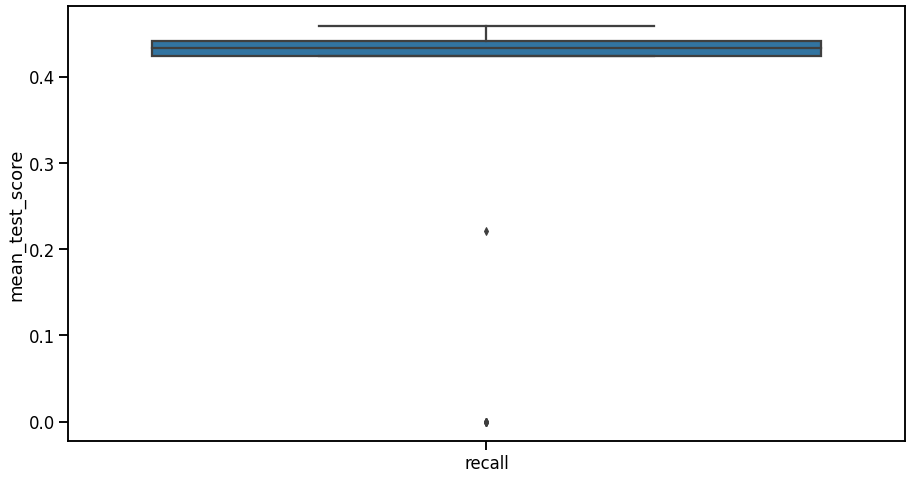

In [85]:
# grafico de boxplot con las 50 mediciones 
all_metrics=cv_results2['mean_test_score']

metric_labels= ['recall']*len(cv_results2['mean_test_score'] )

sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(metric_labels,all_metrics)

In [86]:
# h
# buscamos los paramtros del mejor arbol
randomcv2.best_params_

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 11}

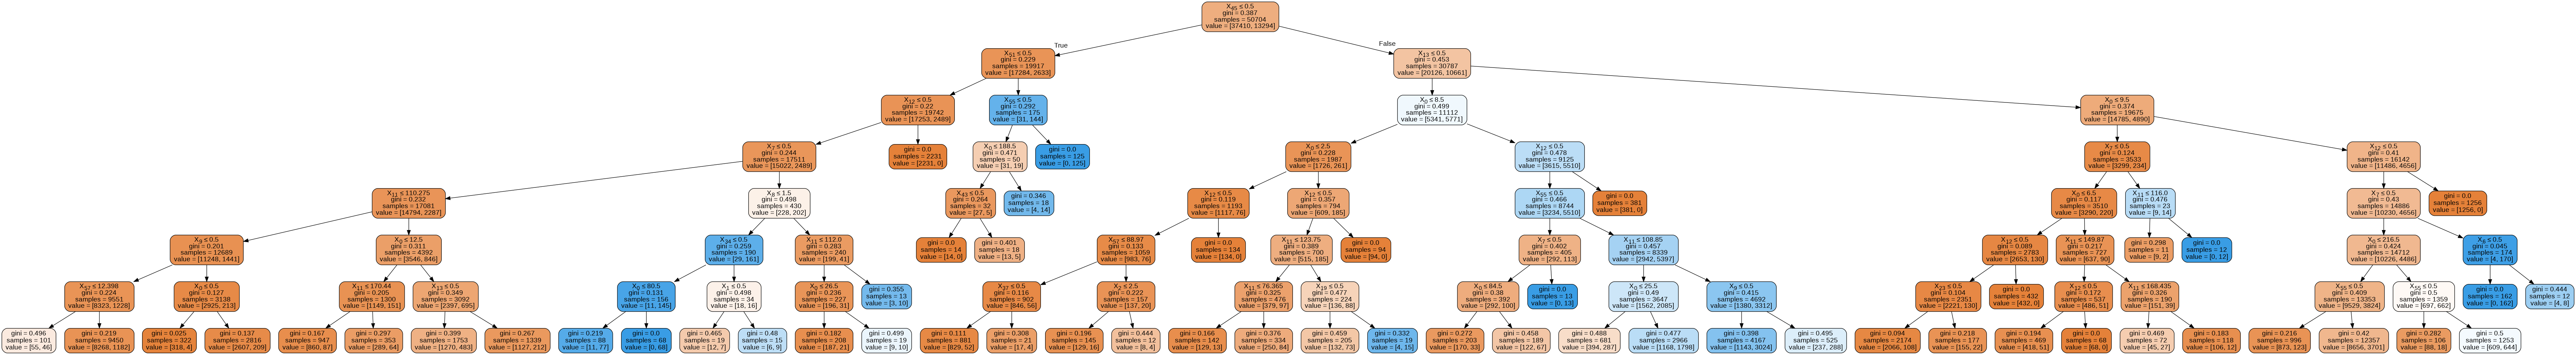

In [87]:
# h
# ejecutamos el mejor arbol
x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed,
                                                      stratify=y_train)

arbol_sklearn2 = randomcv2.best_estimator_
arbol_sklearn2.fit(x_train_,y_train_)

y_pred_val = arbol_sklearn2.predict(x_val)

# graficamos el mejor arbol
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol_sklearn2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [88]:
# vamos los atributos mas importantes del mejor arbol
a = pd.DataFrame(arbol_sklearn2.feature_importances_, df_booking[features].columns)
a.columns=["importancia"]

a[a.importancia>0].sort_values(by="importancia", ascending=False)


,importancia
lead_time,0.245166
market_seg_Online TA,0.220314
total_of_special_requests,0.211156
required_car_parking_spaces,0.121824
previous_cancellations,0.055168
cust_type_Transient,0.042221
deposit_Non Refund,0.033475
adr,0.032276
previous_bookings_not_canceled,0.019293
booking_changes,0.009274


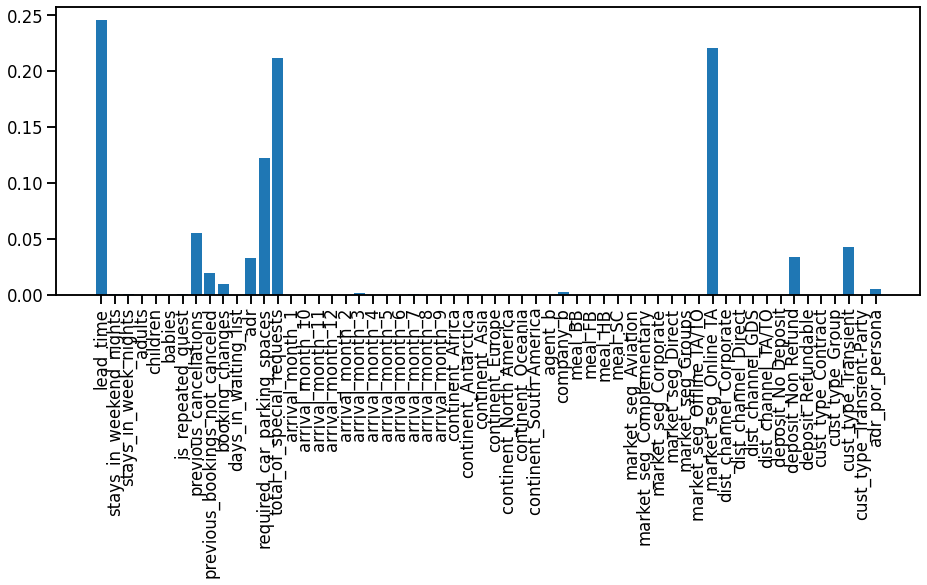

In [89]:
# grafico de importance features
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(features,arbol_sklearn2.feature_importances_)
plt.xticks(features, rotation = 90)
plt.show()

In [90]:
# el recall obtenido del mejor arbol
recall_score(y_val,y_pred_val)


0.4389290012033694

In [91]:
# i)
# tomando el mejor arbol del punto anterior
# le variamos la poda y analizamos
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from array import array

# armo los hiperparaetros fijos con los valores del mejor arbol
crit=[]
crit.append(arbol_sklearn2.criterion)

depth=[]
depth.append(arbol_sklearn2.max_depth)

min_sam=[]
min_sam.append(arbol_sklearn2.min_samples_leaf)

params_grid = {'criterion':crit,
               'max_depth':depth,
               'ccp_alpha':np.linspace(0,0.5,100),
               'min_samples_leaf':min_sam}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(recall_score)
randomcv3 = RandomizedSearchCV(estimator=base_tree,param_distributions = params_grid,scoring=scorer_fn,cv=kfoldcv,n_iter=10,random_state=None)
randomcv3.fit(x_train_,y_train_)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0....
       0.4040404 , 0.40909091, 0.41414141, 0.41919192, 0.42424242,
       

In [92]:
# buscamos los paramtros del mejor arbol
randomcv3.best_params_

{'ccp_alpha': 0.08080808080808081,
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_leaf': 11}

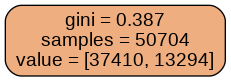

In [109]:
# ejecutamos el mejor arbol
x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42,
                                                      stratify=y_train)

arbol_sklearn3= randomcv3.best_estimator_
arbol_sklearn3.fit(x_train_,y_train_)

y_pred_val = arbol_sklearn3.predict(x_val)

# graficamos el mejor arbol

dot_data = StringIO()
export_graphviz(arbol_sklearn3, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [0]:
# Hacer gráficos de la performance en validación y entrenamiento en función del α
# usamos cost_complexity_pruning_path

# cost_complexity_pruning_path  nos devuelve los alphas efectivos y sus correspondiente total de hojas impuras
# para cada paso del proceso de podado. A medida que alpha incrementa, el podado se incrementa y ésto aumenta
# el total de impureza de sus hojas

x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42,
                                                     stratify=y_train)

path = arbol_sklearn3.cost_complexity_pruning_path(x_train_, y_train_)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for x in ccp_alphas:
  # aplico los mejores parametros del arbol generado con poda
  # pero varia el alpha
  clf= DecisionTreeClassifier(criterion=arbol_sklearn3.criterion, max_depth=arbol_sklearn3.max_depth,
                              min_samples_leaf=arbol_sklearn3.min_samples_leaf, ccp_alpha=x,
                              random_state=42)
  clf.fit(x_train_,y_train_)
  clfs.append(clf)
  

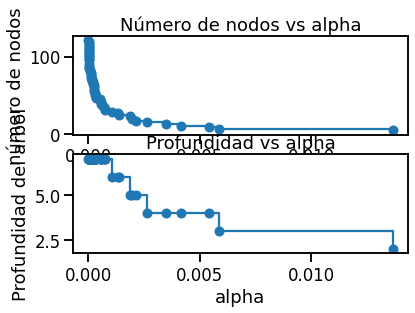

In [97]:
# comparamos la profundidad de los nodos y el nro de nodos vs los valores de alpha
# en el arbol con poda
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("número de nodos")
ax[0].set_title("Número de nodos vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("Profundidad del arbol")
ax[1].set_title("Profundidad vs alpha")


plt.show()
#fig.tight_layout()

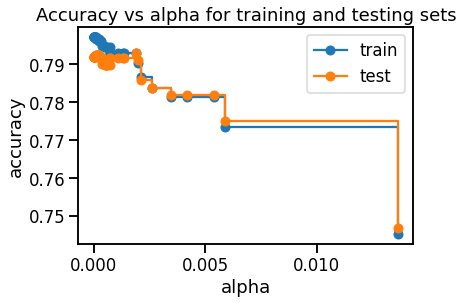

In [98]:
# comparamos la profundidad de los arboles y el nro de nodos vs los valores de alpha
train_scores = [clf.score(x_train_, y_train_) for clf in clfs]
val_scores = [clf.score(x_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

F1 score de arbol CON poda en Test 0.5439318665720368
Recall de arbol CON poda en Test 0.4611311672683514


Text(19.5, 0.5, 'Predicted')

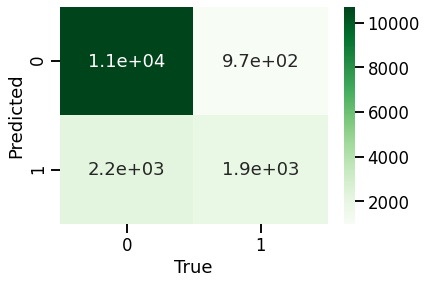

In [99]:
# j)
# Evaluar en el conjunto de evaluación, el árbol correspondiente 
# al α que maximice la performance en el conjunto de validación. Comparar con el caso sin poda (α=0)
from sklearn.metrics import  confusion_matrix, classification_report

# Hacemos la prediccion en test para arbol sin poda
y_pred_val_s_poda = arbol_sklearn2.predict(x_test)

print("F1 score de arbol CON poda en Test {}".format(f1_score(y_test,y_pred_val_s_poda))) 
print("Recall de arbol CON poda en Test {}".format(recall_score(y_test,y_pred_val_s_poda))) 
cm_s_poda= confusion_matrix(y_test,y_pred_val_s_poda)

sns.heatmap(cm_s_poda, cmap='Greens',annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')

F1 score de arbol CON poda en Test 0.0
Recall de arbol CON poda en Test 0.0


Text(19.5, 0.5, 'Predicted')

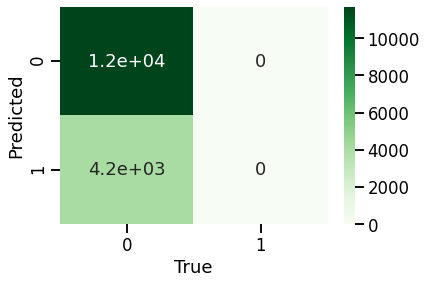

In [100]:

from sklearn.metrics import  confusion_matrix, classification_report

# Hacemos la prediccion en test para arbol con poda
y_pred_val_c_poda = arbol_sklearn3.predict(x_test)

print("F1 score de arbol CON poda en Test {}".format(f1_score(y_test,y_pred_val_c_poda))) 
print("Recall de arbol CON poda en Test {}".format(recall_score(y_test,y_pred_val_c_poda))) 
cm_c_poda=  confusion_matrix(y_test,y_pred_val_c_poda)

sns.heatmap(cm_c_poda, cmap='Greens',annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


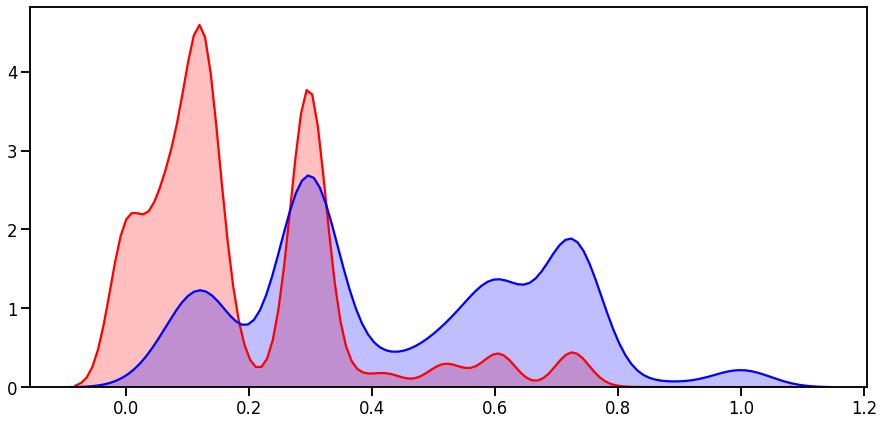

In [101]:
# seguimos comparando ambos arboles
# comparamos las probabilidades 
# sin poda
y_scores = arbol_sklearn2.predict_proba(x_test)
out_probs_2 = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs_2[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs_2[y_test==1],shade=True,c='b')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in

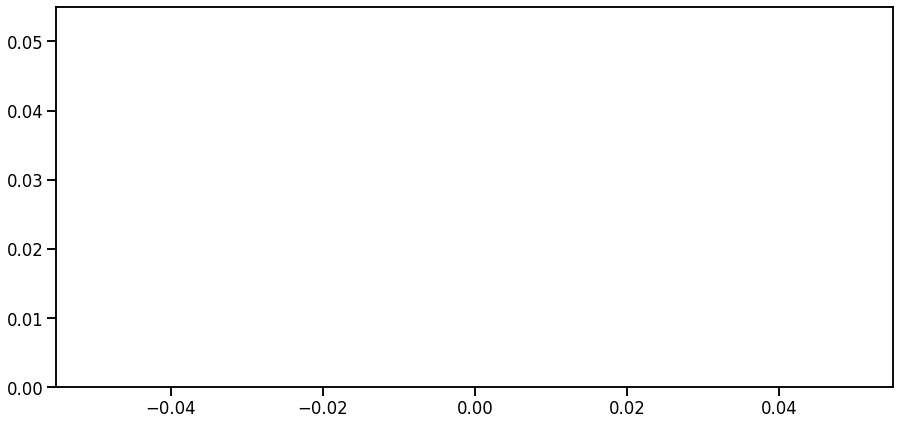

In [102]:
# con poda
y_scores = arbol_sklearn3.predict_proba(x_test)
out_probs_3 = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs_3[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs_3[y_test==1],shade=True,c='b')

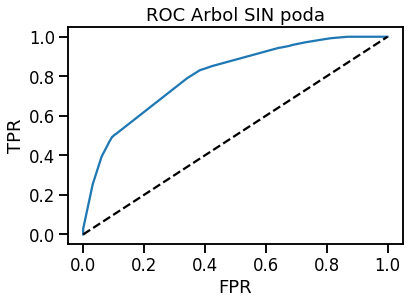

In [103]:
# curva roc arbol,sin poda

from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.metrics import roc_auc_score

fpr,tpr,th = roc_curve(y_test,out_probs_2)

plt.title('ROC Arbol SIN poda')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,fpr,'--k')

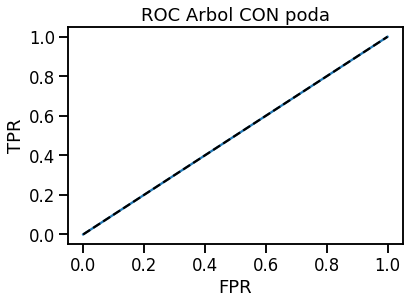

In [104]:
# curva roc arbol,con poda
fpr,tpr,th = roc_curve(y_test,out_probs_3)

plt.title('ROC Arbol CON poda')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr,fpr,'--k')

In [105]:
# algoritmo que hay que usar para el ultimo punto

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE
from sklearn.svm import SVR


x_train_, x_val, y_train_, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42,
                                                      stratify=y_train)


selector = RFE(estimator=arbol_sklearn3, n_features_to_select=3, step=1)
selector = selector.fit(x_train_, y_train_)

selector.support_


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True])

In [106]:
selector.ranking_

array([56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40,
       39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23,
       22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,
        5,  4,  3,  2,  1,  1,  1])

In [107]:
# toma los ultimos 3 atributos xq son los mejor rankeados
df_booking[features].columns[-3:]


Index(['cust_type_Transient', 'cust_type_Transient-Party', 'adr_por_persona'], dtype='object')